In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import random

# **1. Prepare the data**

Let's get the data ready. Since we're using a **pretrained ResNet-18**, we can't just feed it raw pixels. The model was trained on **ImageNet**, so our CIFAR-10 images need to be "prepped" to look like what the model expects.

### **The Preprocessing Pipeline**

We need to perform three critical steps:

1. **Resize**: ResNet-18 expects $ 224 \times 224 $ images, but CIFAR-10 is only $ 32 \times 32 $. We'll upsample them.
2. **To Tensor**: Convert the images into PyTorch tensors.
3. **Normalize**: We must use the specific Mean and Standard Deviation used during the original ImageNet training:
*  $ Mean : [0.485, 0.456, 0.406] $
*  $ Std : [0.229, 0.224, 0.225] $

### **Why Upsampling?**

Because **ResNet-18** was trained on large ImageNet images $ (224 \times 224) $, we need to "resize" the tiny $ 32 \times 32 $ CIFAR images so the pretrained filters can recognize the features.
By resizing $ 32 \times 32 $ up to $ 224 \times 224 $ , the image will look a bit blurry to a human, but for the **ResNet-18 filters**, it ensures that the "features" (like the curve of a car tire or the wing of a plane) align with the sizes the model learned on ImageNet.


In [2]:
# This is the part that actually downloads the 160MB+ CIFAR-10 dataset
# 1. ImageNet-standard normalization and Resizing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. Load Datasets (download=True will fetch them into your data/ folder)
train_set = datasets.CIFAR10(
    root='./fine_tuning_pretrained_model/data',       # Path to your local data folder
    train=True, 
    download=True,
    transform=transform
)

# subsampling for speed. we take the first 5000 indices
subset_indices = list(range(5000))
train_subset = Subset(train_set, subset_indices)

test_set = datasets.CIFAR10(
    root='./fine_tuning_pretrained_model/data',
    train=False, 
    download=True,
    transform=transform
)
# added num_workers (users extra cores)
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

/home/p_retrover/github/basic_machine_learning/.venv/lib64/python3.14/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


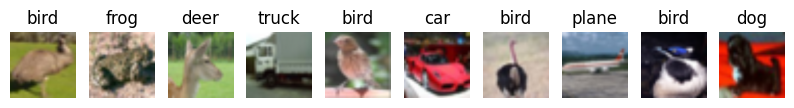

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 3. Visualization Function
def imshow(img):
    # Un-normalize for viewing
    img = img.clone().detach().cpu().numpy()
    img = img.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# Get random images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images in a grid
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    imshow(images[i])
    plt.title(classes[labels[i]])
plt.show()

# **2. The "Model Surgery"**

Now we load the "brain" and modify it. We will "freeze" the weights of the early layers so we don't destroy the pretrained knowledge during the first few epochs.

In [4]:

# 1. Load the Pretrained weights
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# 2. Freeze all "backbone" layers (Feature Extraction)
# This ensures we don't ruin the pretrained ImageNet knowledge early on
for param in model.parameters():
    param.requires_grad = False

# 3. Modify the final layer (The 'Head')
# ResNet-18's last layer is named 'fc' (Fully Connected)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10) # 10 = Number of CIFAR-10 classes

# 4. Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model surgery complete. Head modified for {num_features} -> 10 classes.")

Model surgery complete. Head modified for 512 -> 10 classes.


In [5]:
# 1. Check if weights are frozen correctly
frozen_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {frozen_params + trainable_params:,}")
print(f"Frozen (Pretrained) params: {frozen_params:,}")
print(f"Trainable (New Head) params: {trainable_params:,}")

# 2. Verify the weights are not just zeros or random
# We look at the first layer's weights. If they are very small and structured, 
# they are likely the pretrained ImageNet filters.
first_layer_weights = next(model.parameters())
print(f"\nMean value of first layer weights: {first_layer_weights.mean().item():.6f}")

if frozen_params > trainable_params and abs(first_layer_weights.mean().item()) > 1e-7:
    print("✅ SUCCESS: Pretrained weights are loaded and the backbone is frozen.")
else:
    print("⚠️ WARNING: The model might be using random weights or the backbone is not frozen.")

Total parameters: 11,181,642
Frozen (Pretrained) params: 11,176,512
Trainable (New Head) params: 5,130

Mean value of first layer weights: 0.000029
✅ SUCCESS: Pretrained weights are loaded and the backbone is frozen.


# **3. Setting up the Loss & Optimizer**

Now that the data is flowing, we need to define how the model will learn. We'll use **Cross-Entropy Loss** and the **Adam Optimizer**. Because we are doing "Feature Extraction" first, we will only tell the optimizer to update the weights of the **final layer**.


## **1. Cross-Entropy Loss**

In our **Logistic Regression** module, we used Binary Cross-Entropy. **Cross-Entropy Loss** (`nn.CrossEntropyLoss`) is the multi-class version of that.

Think of it as a penalty system:

* **The Model's Output**: For an image of a "frog," the model outputs "probabilities" for all 10 classes (e.g., Cat: 0.1, Dog: 0.2, Frog: 0.7).
* **The Penalty**: The loss function looks at the probability assigned to the *correct* class (Frog).
    * If the model is 99% sure it’s a frog, the loss is near **0**.
    * If the model thinks it's a dog and only gives frog 10%, the loss is **high**.



> **Note**: Cross-Entropy combines a **LogSoftmax** and **NLLLoss** (Negative Log Likelihood Loss) into one single class for numerical stability. It uses the formula:
> 
> $$ L = -\sum_{i=1}^{C} y_i \log(\hat{y}_i) $$
> 
> where $ y $ is the ground truth and $ \hat{y} $ is the predicted probability.

---

## **2. Adam Optimizer**

In our from-scratch implementations, we used **Stochastic Gradient Descent (SGD)**, where we subtract the gradient multiplied by a fixed learning rate: $ W = W - \eta \cdot \nabla L $.

**Adam (Adaptive Moment Estimation)** is like SGD with "Intelligence" and "Momentum." It solves two big problems we face when training on a CPU:

* **Momentum (The Ball Rolling Downhill)**: It keeps a "moving average" of previous gradients. If the gradient has been pointing "down" for the last few steps, it gains speed. This helps it skip over local minima in the loss surface.
* **Adaptive Learning Rates**: It tracks how much each specific weight changes.
    * If a weight is changing wildly, it slows down its learning rate for that weight to keep it stable.
    * If a weight is barely moving, it speeds up the learning rate for that weight to find the solution faster.



# **4. Fine Tuning and Learning Rate Scheduler**
## **The Two Stages of Fine-Tuning**

#### **1. Feature Extraction (What we are doing now)**

* **Action**: Freeze the entire backbone; only train the final `fc` (head) layer.
* **Why**: The ResNet-18 "backbone" already knows how to see shapes, textures, and edges from ImageNet. You are just teaching it how to map those shapes to "CIFAR-10" categories.

#### **2. Fine-Tuning**

* **Action**: Unfreeze the top 1 or 2 blocks of the ResNet backbone and train them with a **very small learning rate**.
* **Why**: ImageNet (1,000 classes) contains many things CIFAR-10 doesn't. By unfreezing a few top layers, you allow the model to slightly adjust its "high-level" filters (like specific animal ear shapes or car grill patterns) to better fit your specific dataset.

>### **Note**
>
>We usually **don't need** to unfreeze the backbone to get passing results. Fine-tuning just the head on CIFAR-10 typically gets you to **70-85% accuracy** very quickly.
>
>**However, you SHOULD unfreeze if:**
>
>1. **Your Accuracy Plateaus**: If you can't get past 60% after 10 epochs.
>2. **The Datasets are Very Different**: If you were training on medical X-rays (which look nothing like ImageNet photos), you would have to unfreeze layers because ImageNet filters wouldn't "see" X-ray features well.
>

### **How to "Partially" Unfreeze**

If you want to try it, don't unfreeze the whole model. Unfreeze only the last "layer block." Here is how you modify your model setup:

```python
# 1. Unfreeze the entire model first
for param in model.parameters():
    param.requires_grad = True

# 2. Refreeze everything except the last block (Layer 4) and the head
# This keeps the basic edge detectors (Layer 1-3) stable
for name, child in model.named_children():
    if name in ['layer4', 'fc']:
        print(f"Unfreezing {name}")
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

```

> **Crucial Warning for fine-tuning:**
>
> If you unfreeze layers, you **must** lower your learning rate. If you keep it at `0.001`, you will likely destroy the pretrained knowledge. Switch to `0.0001` or lower.
>

---

## **Learning Rate Scheduler**

In our first-principles implementations of Logistic Regression, we used a **fixed learning rate** ($\eta$). However, in deep learning, using one speed for the entire trip is rarely optimal.

**Learning Rate Scheduling** is the strategy of adjusting the learning rate during the training process.

### **1. The Problem**

If you keep the learning rate high throughout training, the model will quickly descend into the "loss valley." However, once it gets near the absolute minimum, the steps are too large. Instead of settling at the bottom, the model **bounces back and forth** across the valley, never quite reaching the lowest possible loss.

### **2. Common Scheduling Strategies**

#### **Step Decay (`StepLR`)**

It reduces the learning rate by a specific factor every few epochs.

* **Example**: Start at $0.01$, and every 7 epochs, multiply by $0.1$.
* **Logic**: Give the model enough time to explore at one speed, then "step down" to refine.

#### **Exponential Decay**

The learning rate is reduced at every single step based on an exponential function.

* **Math**: $\eta_t = \eta_0 \cdot e^{-kt}$
* **Logic**: A smoother, more continuous slowdown compared to the Step Decay.

#### **Reduce On Plateau (`ReduceLROnPlateau`)**

This is a "reactive" scheduler. It monitors the validation loss. If the loss hasn't improved for, say, 3 epochs, the scheduler assumes the model is stuck and drops the learning rate.

* **Logic**: "If it's not working, slow down and try to be more precise."

### **3. Why to use it?**

When you are fine-tuning a pretrained model, the weights are already very good.

1. **Early On**: A slightly higher rate helps the new `fc` layer quickly align with the CIFAR-10 labels.
2. **Later On**: As the accuracy hits $70 - 80\%$, you need a much smaller learning rate to find the tiny adjustments that push you toward $90\%$.

>### **Note**
>
>You can view the loss surface as a high-dimensional manifold. A scheduler helps the optimizer navigate the trade-off between **exploration** (finding the right valley) and **exploitation** (finding the deepest point in that valley).
>
> **A Note on Adam:** You might wonder, "Doesn't the Adam optimizer already do this?"
> **Yes and no.** Adam adapts the learning rate for *each parameter* based on its history. However, a **Global Scheduler** (like `StepLR`) reduces the entire learning rate for the whole model.


In [6]:
learning_rate = 0.001
no_of_epochs = 10
# for StepLR step size
stepLR_step_size = 7

In [7]:
# 1. Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()

# Only optimize parameters that require gradients
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

# 2. Learning Rate Scheduler
# This decays the learning rate by a factor of 0.1 every 7 epochs
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=stepLR_step_size, gamma=0.1)

def train_model(model, criterion, optimizer, scheduler, num_epochs=no_of_epochs):
    train_loss_history = []
    lr_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        # --- TRAINING PHASE ---
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad() # Reset gradients
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward() # Backpropagation
            optimizer.step() # Update weights
            running_loss += loss.item() * inputs.size(0)

        # --- VALIDATION PHASE ---
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

        # Step the scheduler
        scheduler.step()
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_val_loss = running_loss /len(test_loader.dataset)

        val_loss_history.append(epoch_val_loss)
        train_loss_history.append(epoch_train_loss)
        lr_history.append(optimizer.param_groups[0]['lr'])
        
        print(f'Epoch {epoch}/{num_epochs - 1} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | LR: {scheduler.get_last_lr()[0]}')

    return train_loss_history, val_loss_history, lr_history


In [8]:
def plot_training_results(loss_hist, lr_hist):
    epochs = range(len(loss_hist))
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Loss on the left axis
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Training Loss', color=color)
    ax1.plot(epochs, loss_hist, color=color, linewidth=2, label='Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second axis for the Learning Rate
    ax2 = ax1.twinx() 
    color = 'tab:blue'
    ax2.set_ylabel('Learning Rate', color=color)
    ax2.step(epochs, lr_hist, color=color, where='post', linewidth=2, label='Learning Rate')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Training Loss vs. Learning Rate Schedule')
    fig.tight_layout()
    plt.show()


In [9]:
def plot_overfitting_analysis(train_loss, val_loss):
    epochs = range(len(train_loss))
    plt.figure(figsize=(10, 6))
    
    plt.plot(epochs, train_loss, 'r-o', label='Training Loss')
    plt.plot(epochs, val_loss, 'b-o', label='Validation Loss')
    
    plt.title('Overfitting Analysis: Training vs. Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


## **Optimizer Speed (LR)**, **Training Progress**, and **Generalization (Overfitting)**

Think of these two plots as different "sensors" on the model's dashboard:

| Plot | Focus | Mathematical Question |
| --- | --- | --- |
| **Training vs. LR** | **Optimization Efficiency** | "Is my learning rate helping the model descend the gradient quickly and smoothly?" |
| **Overfitting Analysis** | **Generalization** | "Is the model actually learning patterns, or is it just memorizing the training images?" |


The most important connection between them happens when you drop the Learning Rate.

* Often, dropping the LR helps the **Training Loss** hit a new low.
* However, if the **Validation Loss** starts rising at that same moment, it means the lower learning rate is helping the model "over-optimize" for specific training pixels—this is the exact moment overfitting begins.


Epoch 0/9 | Train Loss: 1.5531 | Val Loss: 0.7765 | LR: 0.001
Epoch 1/9 | Train Loss: 0.9450 | Val Loss: 0.4725 | LR: 0.001
Epoch 2/9 | Train Loss: 0.7759 | Val Loss: 0.3880 | LR: 0.001
Epoch 3/9 | Train Loss: 0.7136 | Val Loss: 0.3568 | LR: 0.001
Epoch 4/9 | Train Loss: 0.6615 | Val Loss: 0.3307 | LR: 0.001
Epoch 5/9 | Train Loss: 0.6172 | Val Loss: 0.3086 | LR: 0.001
Epoch 6/9 | Train Loss: 0.5906 | Val Loss: 0.2953 | LR: 0.0001
Epoch 7/9 | Train Loss: 0.5617 | Val Loss: 0.2808 | LR: 0.0001
Epoch 8/9 | Train Loss: 0.5575 | Val Loss: 0.2787 | LR: 0.0001
Epoch 9/9 | Train Loss: 0.5526 | Val Loss: 0.2763 | LR: 0.0001


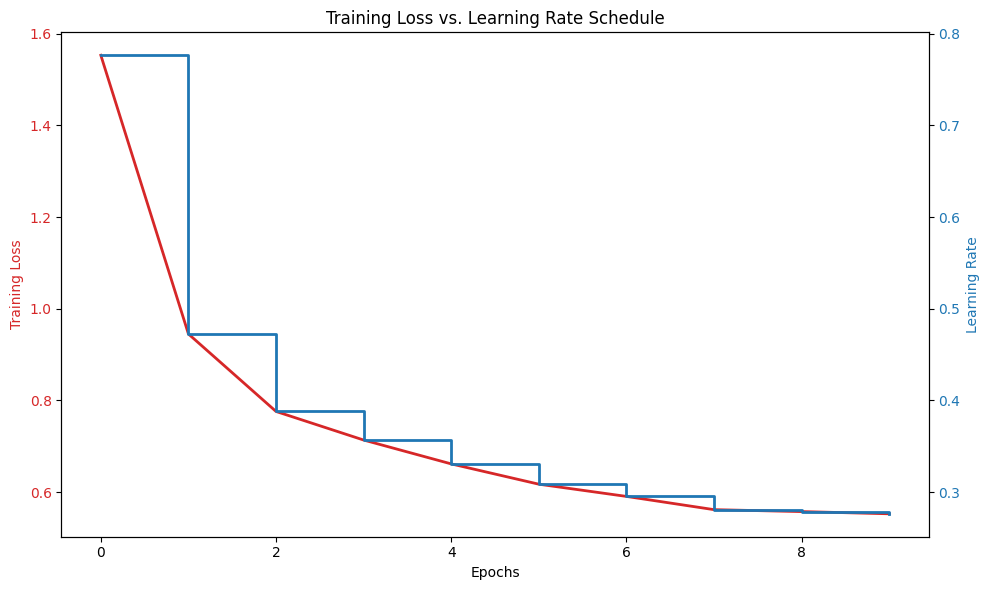

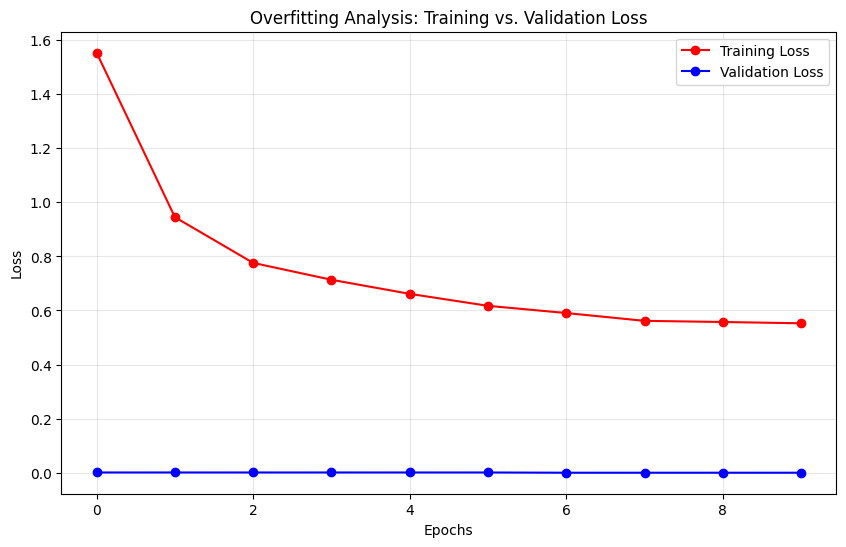

In [10]:
# Run the plot
train_loss_history, lr_history, val_loss_history= train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=no_of_epochs)
plot_training_results(train_loss_history, lr_history)
plot_overfitting_analysis(train_loss_history, val_loss_history)

# **5. Evaluation**

### **Quick Definitions**

* **Accuracy**: $\frac{\text{Correct Predictions}}{\text{Total Predictions}}$. Simple, but can be misleading if classes are imbalanced.
* **Precision**: $\frac{\text{True Positives}}{\text{True Positives}+\text{False Positives}}$. "Of all the times the model guessed 'Cat', how many were actually cats?"
* **Recall**: $\frac{\text{True Positives}}{\text{True Positives}+\text{False Negatives}}$. "Of all the actual 'Cats' in the dataset, how many did the model find?"
* **F1-Score**: $2\cdot\frac{\text{Precision} \cdot \text{Recall}}{\text{Precision}+\text{Recall}}$. The harmonic mean of Precision and Recall. Use this to show if the model is balanced.


In [11]:
def evaluate_model(model, loader, device):
    model.eval() # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad(): # No need to calculate gradients
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    
    # 'macro' calculates metrics for each label and finds their unweighted mean
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro'
    )

    return all_labels, all_preds, accuracy, precision, recall, f1

# Execute Evaluation
labels, preds, acc, prec, rec, f1_val = evaluate_model(model, test_loader, device)

print(f"Overall Accuracy: {acc*100:.2f}%")
print(f"Macro Precision:  {prec:.4f}")
print(f"Macro Recall:     {rec:.4f}")
print(f"Macro F1-Score:   {f1_val:.4f}")
target_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print("\n--- Detailed Classification Report ---")
print(classification_report(labels, preds, target_names=target_names))

Overall Accuracy: 77.59%
Macro Precision:  0.7774
Macro Recall:     0.7759
Macro F1-Score:   0.7756

--- Detailed Classification Report ---
              precision    recall  f1-score   support

       plane       0.82      0.76      0.79      1000
         car       0.90      0.84      0.87      1000
        bird       0.75      0.69      0.72      1000
         cat       0.63      0.66      0.64      1000
        deer       0.76      0.74      0.75      1000
         dog       0.76      0.69      0.73      1000
        frog       0.76      0.85      0.80      1000
       horse       0.77      0.80      0.79      1000
        ship       0.79      0.87      0.83      1000
       truck       0.84      0.86      0.85      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



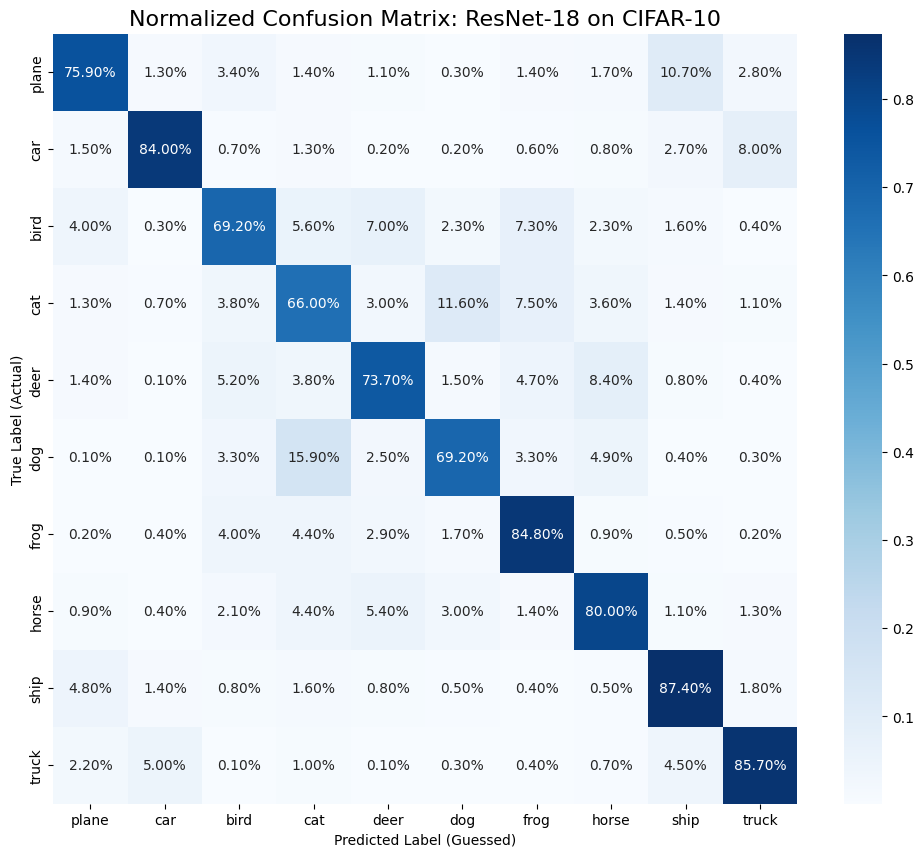

In [12]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    # 1. Create the Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # 2. Normalize it (to see percentages instead of just raw counts)
    cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # 3. Setup the plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_perc, annot=True, fmt='.2%', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    
    plt.title('Normalized Confusion Matrix: ResNet-18 on CIFAR-10', fontsize=16)
    plt.ylabel('True Label (Actual)', fontsize=10)
    plt.xlabel('Predicted Label (Guessed)', fontsize=10)
    plt.show()

# Run the visualizer using the 'labels' and 'preds' from the evaluation function
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(labels, preds, class_names)

# **6. Inference**

we’ll create a visualization that picks random images from the test set and displays them with their predicted vs. actual labels.
We will color-code the titles: **Green** if the model got it right, and **Red** if it failed.

### **1. Denormalization Utility**

Since we normalized our images for the ResNet model (making them look weirdly dark/colored to the human eye), we need to "undo" that math so they look normal in the plot.

### **2. The Visualizer Function**

* **The Green Successes**: Shows the model has learned the general features of planes, cars, etc.
* **The Red Failures**: Look at the red ones. Is the "Actual" image very blurry? Is a "Truck" angled in a way that looks like a "Car"?



In [13]:
def denormalize(tensor):
    # Reverse of: (x - mean) / std  =>  x * std + mean
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

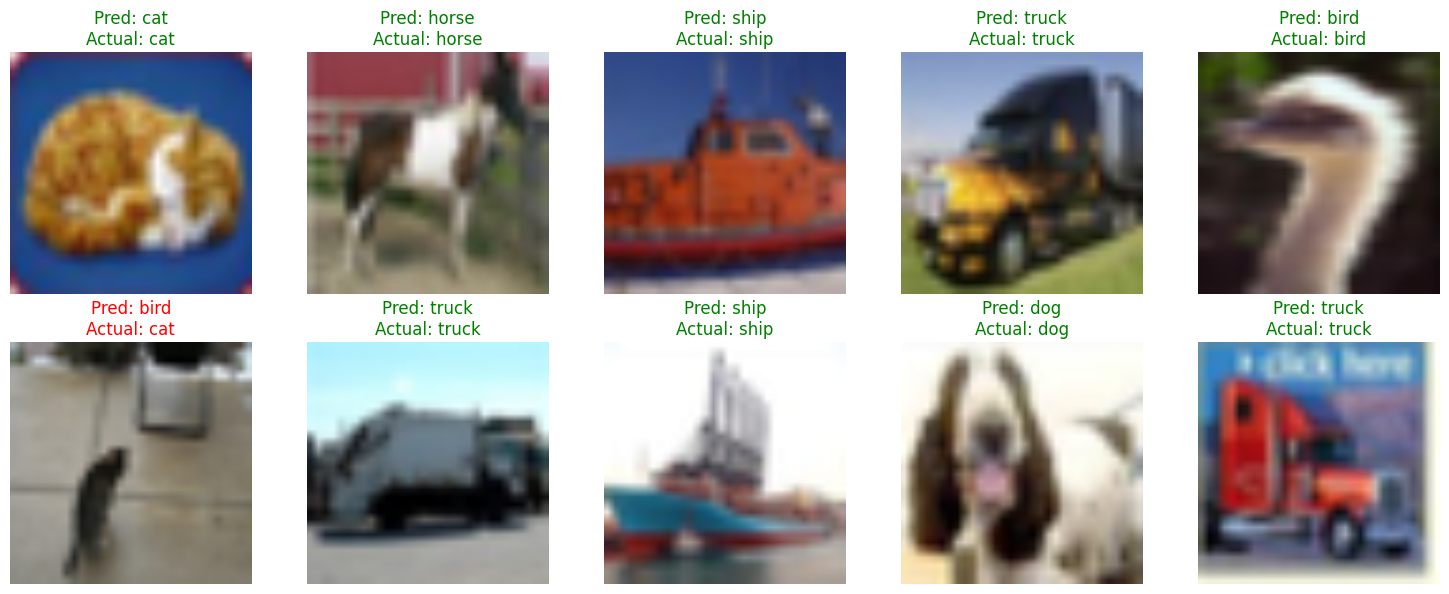

In [14]:
def visualize_predictions(model, dataset, class_names, num_images=10):
    model.eval()

    indices = random.sample(range(len(dataset)), num_images)

    images = torch.stack([dataset[i][0] for i in indices])
    labels = torch.tensor([dataset[i][1] for i in indices])

    # Get predictions
    with torch.no_grad():
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu().numpy()

    # Plotting
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        
        # Prepare image for display (C, H, W) -> (H, W, C)
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1) # Ensure pixel values are in [0, 1]
        
        plt.imshow(img)
        color = 'green' if preds[i] == labels[i].item() else 'red'
        plt.title(f"Pred: {class_names[preds[i]]}\nActual: {class_names[labels[i]]}", color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Run the visualizer
visualize_predictions(model, test_set, class_names)